# TPS-JUNE 2021 :

![](https://storage.googleapis.com/kaggle-competitions/kaggle/25225/logos/header.png?t=2021-01-27-17-34-26)


## UPVOTE if this helps you :)

This is a quick starter for TPS-kaggle.

All the major steps have been used to find the best accuracy using the most fundamental approach.

This notebook not only holds a better way to appproach any other competition , but it observes and manipulates the small and tiny changes that can lead us to a better Data Engineering. 

In [1]:
!pip install catboost

     |████████████████████████████████| 67.3MB 57kB/s 


In [2]:
!pip install -q kaggle

!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c tabular-playground-series-jun-2021

  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 39.9MB/s]
  0% 0.00/6.49M [00:00<?, ?B/s]
100% 6.49M/6.49M [00:00<00:00, 59.6MB/s]
  0% 0.00/3.14M [00:00<?, ?B/s]
100% 3.14M/3.14M [00:00<00:00, 104MB/s]


In [4]:
from glob import glob

In [5]:
from zipfile import ZipFile
for fil in glob('/content/*zip'):
  zf = ZipFile(fil, 'r')
  zf.extractall('/content')
  zf.close()

#### Data Gathering :

In [6]:
root = '../input/tabular-playground-series-jun-2021/'
root = '/content/'
train_path = root + 'train.csv'
test_path = root + 'test.csv'
subm_path = root + 'sample_submission.csv'

#### Libraries :

Importing the basic data manipulation and visulaization libraries.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Data Loading :
After loading the data into dataframe / python backend , we can visualize the deeper patterns or can manipulate it on our wish.

In [8]:
train_df = pd.read_csv(train_path)

train_df.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,target
0,0,0,0,6,1,0,0,0,0,7,0,0,0,3,0,1,0,0,3,3,1,0,2,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,11,0,0,0,0,0,9,0,0,0,0,0,0,3,0,1,3,0,0,0,0,0,0,0,1,1,0,0,3,0,0,0,0,0,0,2,0,0,Class_6
1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,Class_6
2,2,0,0,0,0,0,1,0,3,0,0,1,0,0,0,0,0,0,0,0,5,4,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,5,0,5,0,1,0,0,0,1,0,0,1,0,7,0,1,1,0,3,4,0,0,1,3,0,2,0,0,8,0,0,0,0,1,0,0,0,0,Class_2
3,3,0,0,7,0,1,5,2,2,0,1,2,0,5,0,0,4,0,0,22,2,1,0,0,0,0,3,0,37,0,1,3,13,0,10,0,3,1,1,0,7,0,0,2,0,1,0,0,0,0,0,0,10,0,0,25,1,0,1,2,0,2,0,7,0,0,0,0,4,0,2,2,0,4,3,0,Class_8
4,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Class_2


In [9]:
test_df = pd.read_csv(test_path)

test_df.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74
0,200000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,200001,1,2,0,0,0,0,0,0,0,0,1,0,2,2,0,0,1,0,0,0,2,0,0,1,0,3,0,1,0,0,2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,3,2,0,0,0,0,0,0,1,7,0,1,3,1,3,0,0,0,0,3,0,0
2,200002,0,1,7,1,0,0,0,0,6,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,2,0,0,4,0,0,0,0,0,0,0,0,1,0,0,4,0,0,1,0,0,0,6,0,0,2,10,0,0,0,2,1,0,0,0,0,0,3,0,0,0,0,3,0,2,0,0
3,200003,0,0,0,4,3,1,0,0,0,0,7,0,0,0,7,0,0,0,5,0,1,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,7,5,0,0,0,0,0,0,0,0,0,2,3,0,0,0,1,0,0,0,0,0,4,0,0,0,1,0,0,0,4,0,0
4,200004,0,0,5,0,0,0,0,0,0,8,1,0,2,0,0,0,0,0,9,1,0,0,0,0,0,0,0,0,3,0,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,2,2,1,5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [10]:
samp_sub = pd.read_csv(subm_path)

samp_sub.head()

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,200000,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111
1,200001,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111
2,200002,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111
3,200003,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111
4,200004,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111,0.1111


The sample submission format tells us that we need to predict the likelihood the target classes . This values are between 0.0 to 1.0.

#### Approach :

 So, now we have to decide the approach. 
 1. We can process the data and feed it through a [neural network](https://en.wikipedia.org/wiki/Neural_network) and output as a [softmax layer](https://en.wikipedia.org/wiki/Softmax_function).
 2. We can use the [predict_proba()](https://discuss.analyticsvidhya.com/t/what-is-the-difference-between-predict-and-predict-proba/67376) to the normal Machine Learning bagging or boosting models and prepare the submission file.

### Exploratory Data Analysis and Data Processing :
---

We'll be trying to visualize the deeper patterns of data and find out the anomalies which should be omittted to prepare the best trainable data.

Also an additional point ,
**BEST TRAINABLE DATA** is a data which has no noise and duplicates and outliers.

1. #### Target Value Count Distribution: 
---
At first we are going to check the target value mass distribution . Cause too much difference in the can led us to a bad model learning.

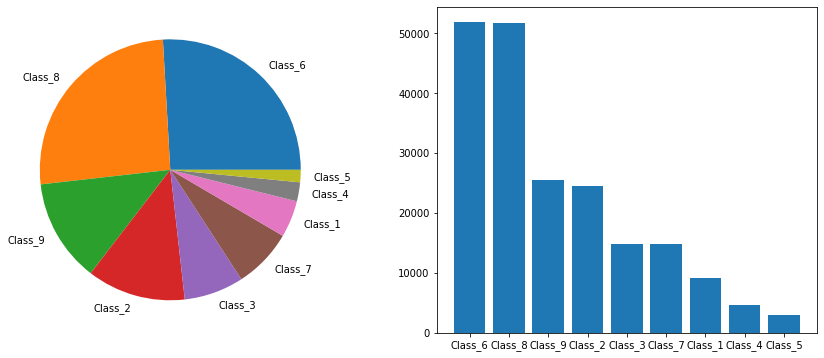

In [11]:
# Target Value Count Distribution:
target_mass = train_df['target'].value_counts()
values = target_mass.values.tolist()
indexes = target_mass.index.tolist()

ax,fig = plt.subplots(1,2,figsize=(15,6))
plt.subplot(1,2,1)
plt.pie(values , labels = indexes)
plt.subplot(1,2,2)
plt.bar(indexes,values)
plt.show()

We can see that some target classes are present in a very big number and some are very less.

#### Approach :
We can take every target class rows in a same count. But choosing that will reduce the data size and as we do not know which data to remove we might even remove the important rows. So, we will skip target class equalization.

 2. #### Correlation :
---
Now , we must check the data correlation . In this part we'll be visualizing feature to feature correlation.

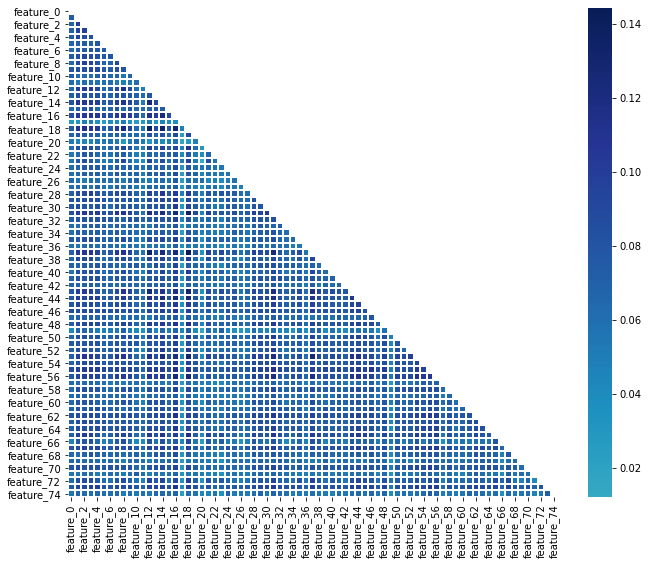

In [12]:
fet_set = train_df.drop(labels=['id','target'],axis=1)
def plot_diag_heatmap(data):
    corr = data.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(11, 9))
    sns.heatmap(corr, mask=mask, cmap='YlGnBu', center=0,square=True, linewidths=1, cbar_kws={"shrink": 1.0})
plot_diag_heatmap(fet_set)

In here we can see some features are light in the whole plot. So, we can indicate those as low correlated features.
So, we are going to drop those feature from train and test data both.

In [13]:
corr = train_df.iloc[:,1:-1].corr()

In [14]:
corr

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74
feature_0,1.000000,0.075635,0.069638,0.069722,0.072082,0.065814,0.062316,0.072485,0.065141,0.078520,0.072671,0.063139,0.064643,0.072482,0.083327,0.064451,0.084252,0.028813,0.075514,0.065440,0.052663,0.061290,0.052213,0.055164,0.062913,0.059797,0.062848,0.060460,0.070405,0.078095,0.075038,0.082878,0.071390,0.062324,0.059320,0.073915,0.058060,0.070288,0.066997,0.070233,0.055098,0.068891,0.066149,0.077252,0.077662,0.079408,0.085800,0.065323,0.074244,0.039733,0.067609,0.075689,0.069561,0.070309,0.069511,0.087259,0.078760,0.063554,0.062852,0.061740,0.063676,0.068510,0.080143,0.070499,0.068937,0.070449,0.046520,0.080818,0.063732,0.064846,0.081230,0.056113,0.062631,0.075857,0.054982
feature_1,0.075635,1.000000,0.098960,0.092471,0.095078,0.071548,0.074330,0.085721,0.090932,0.085114,0.063976,0.053101,0.100512,0.084193,0.107739,0.075386,0.104169,0.032414,0.108273,0.078580,0.045028,0.083342,0.064021,0.075352,0.069166,0.067507,0.057660,0.064802,0.089130,0.081283,0.084571,0.101993,0.081290,0.062960,0.075270,0.079594,0.058442,0.105551,0.091144,0.068827,0.083808,0.079801,0.070046,0.099174,0.100569,0.095365,0.086195,0.070514,0.090663,0.065841,0.085077,0.079311,0.086873,0.098310,0.080246,0.097731,0.095627,0.062967,0.086580,0.068215,0.080796,0.080137,0.088044,0.085609,0.086999,0.095708,0.076696,0.087203,0.062677,0.065639,0.088703,0.056991,0.084944,0.094933,0.065490
feature_2,0.069638,0.098960,1.000000,0.096866,0.084577,0.074458,0.073986,0.091439,0.097344,0.082069,0.061997,0.059514,0.101942,0.085103,0.104033,0.076047,0.101822,0.050333,0.115918,0.077045,0.042984,0.087704,0.075998,0.085128,0.074570,0.070625,0.052416,0.067081,0.087757,0.085315,0.078255,0.106026,0.080523,0.069745,0.067195,0.082082,0.062625,0.106814,0.087425,0.073608,0.078755,0.077901,0.069786,0.101281,0.091067,0.082718,0.088331,0.070663,0.088963,0.066440,0.085111,0.076408,0.080390,0.106593,0.085496,0.100531,0.096096,0.061780,0.081452,0.071445,0.078623,0.073717,0.086575,0.086283,0.082640,0.100290,0.078463,0.094978,0.066450,0.060703,0.079420,0.062092,0.087096,0.089565,0.061419
feature_3,0.069722,0.092471,0.096866,1.000000,0.082561,0.071485,0.078161,0.084732,0.094637,0.091393,0.058894,0.060427,0.102103,0.076990,0.099843,0.081842,0.106307,0.050725,0.107894,0.072256,0.045001,0.088376,0.079836,0.073716,0.077985,0.070648,0.060609,0.057805,0.098117,0.084237,0.075567,0.098972,0.079998,0.074440,0.072325,0.086280,0.067789,0.107160,0.091865,0.070118,0.083840,0.084831,0.073608,0.097456,0.102993,0.090002,0.088514,0.074487,0.097042,0.063215,0.080865,0.081642,0.077227,0.102542,0.089206,0.101286,0.098104,0.068196,0.082743,0.069297,0.082745,0.079541,0.090797,0.084121,0.082735,0.095962,0.082796,0.086724,0.080888,0.065390,0.084999,0.062902,0.086431,0.096262,0.060879
feature_4,0.072082,0.095078,0.084577,0.082561,1.000000,0.078421,0.076111,0.083905,0.080090,0.089852,0.070886,0.057609,0.091414,0.082670,0.098899,0.064397,0.106523,0.036713,0.100857,0.071820,0.055859,0.076815,0.064638,0.064350,0.075847,0.072592,0.060624,0.069303,0.082410,0.083602,0.082434,0.101816,0.082978,0.075125,0.072203,0.075878,0.059575,0.096901,0.070344,0.079664,0.078206,0.083516,0.067725,0.084018,0.096159,0.080561,0.085226,0.067056,0.

We are going to drop those features which are below that basline.

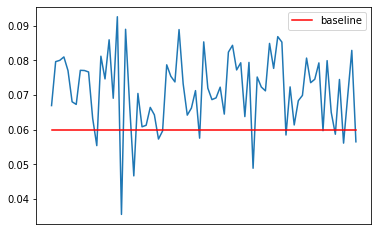

In [15]:
plt.plot((abs(corr).sum()-1)/len(corr))
plt.xticks([])
plt.plot(np.ones(len(corr))*0.06,label = 'baseline',color = 'r')
plt.legend()
plt.show()

In [16]:
for col in corr.columns:
    if ((sum(corr[col])-1)/(len(corr)-1)) <0.06:
        print(col , (sum(corr[col])-1)/(len(corr)-1))

feature_11 0.05609849461678657
feature_17 0.03598319570105301
feature_20 0.04725018873860061
feature_26 0.05802429527542317
feature_36 0.058281007034191104
feature_49 0.049483980625724504
feature_57 0.05920260789993294
feature_69 0.05942356184811063
feature_71 0.05683114485073222
feature_74 0.05721653666909726


In [17]:
for col in corr.columns:
    if ((sum(corr[col])-1)/(len(corr)-1)) <0.06:
        train_df.drop(col,1,inplace=True)
        test_df.drop(col,1,inplace=True)

In [18]:
train_df.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_12,feature_13,feature_14,feature_15,feature_16,feature_18,feature_19,feature_21,feature_22,feature_23,feature_24,feature_25,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_70,feature_72,feature_73,target
0,0,0,0,6,1,0,0,0,0,7,0,0,3,0,1,0,0,3,1,2,0,0,0,0,0,1,0,0,1,0,0,0,0,11,0,0,0,0,0,9,0,0,0,0,0,3,0,1,3,0,0,0,0,0,0,1,1,0,0,3,0,0,0,0,2,0,Class_6
1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,Class_6
2,2,0,0,0,0,0,1,0,3,0,0,1,0,0,0,0,0,0,5,0,0,0,0,0,0,0,1,0,0,0,0,2,0,5,0,5,0,1,0,0,0,1,0,0,1,7,0,1,1,0,3,4,0,1,3,0,2,0,0,8,0,0,0,1,0,0,Class_2
3,3,0,0,7,0,1,5,2,2,0,1,2,5,0,0,4,0,22,2,0,0,0,0,3,37,0,1,3,13,0,10,0,3,1,0,7,0,0,2,0,1,0,0,0,0,0,10,0,0,25,1,0,2,0,2,0,7,0,0,0,0,4,0,2,4,3,Class_8
4,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Class_2


In [19]:
train_df.describe()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_12,feature_13,feature_14,feature_15,feature_16,feature_18,feature_19,feature_21,feature_22,feature_23,feature_24,feature_25,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_70,feature_72,feature_73
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000
mean,99999.500000,0.972710,1.168365,2.219325,2.296735,0.793530,1.431105,1.010695,0.673090,1.94398,1.719655,1.422550,2.444760,1.078085,1.406445,1.413200,1.389720,1.656610,6.186895,1.031415,1.465935,0.572000,1.061165,2.348775,0.789325,2.326190,1.581820,0.598825,1.856545,1.516105,1.556650,0.681135,1.162070,1.500505,1.276080,2.332940,1.255005,1.159385,0.834600,4.472965,0.890300,0.690865,2.413920,0.969055,1.527270,2.275075,1.617085,0.622570,1.354225,6.008040,2.493365,2.118190,0.927100,1.343715,1.666660,1.287270,2.764225,1.455190,0.696915,1.798040,0.508695,1.827300,0.910370,1.219210,1.282925,2.94021
std,57735.171256,3.941836,3.993407,6.476570,7.551858,2.935785,5.162746,3.949231,2.234949,3.93133,5.916988,3.288376,3.421765,3.713650,2.868740,8.240441,3.056888,2.557042,13.982531,2.931762,6.734983,1.676326,5.718083,7.319992,3.517043,8.402752,5.565404,1.418070,3.898896,7.782723,3.913513,2.307127,3.443417,2.900480,4.268174,4.523171,4.482382,5.407836,3.496194,7.723795,2.150593,2.188692,9.774465,5.845938,4.375537,5.227827,5.149637,1.953864,2.960980,11.286352,8.787684,4.107152,2.697104,6.168400,6.387178,5.480586,8.251200,7.121127,2.185252,5.053014,1.867330,7.188924,3.835182,4.826003,4.261420,10.78465
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,49999.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

3. #### Outliers :
---
As the outliers can not be distinguished very properly but can stay in the data as a noise. We can visualize the outliers using [seaborn boxplots](https://seaborn.pydata.org/generated/seaborn.boxplot.html).

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

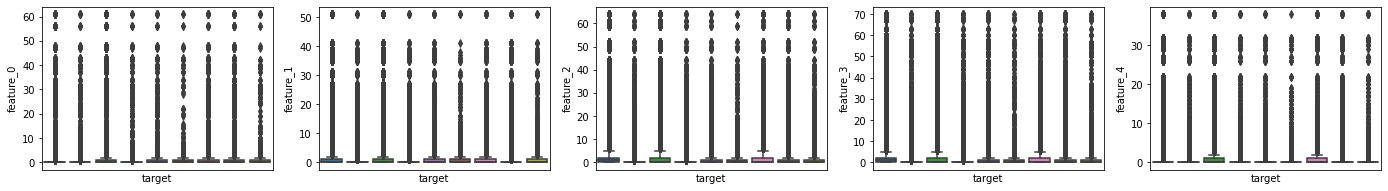

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

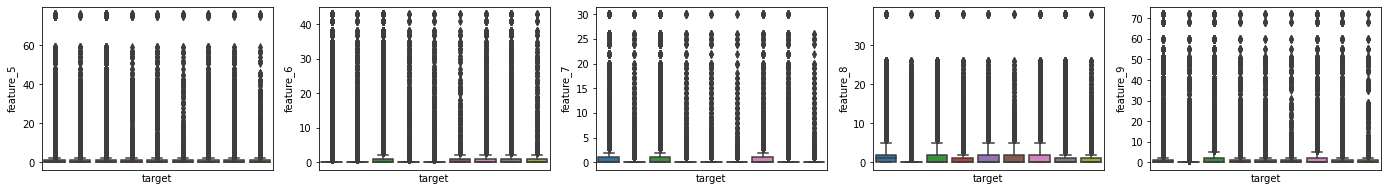

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

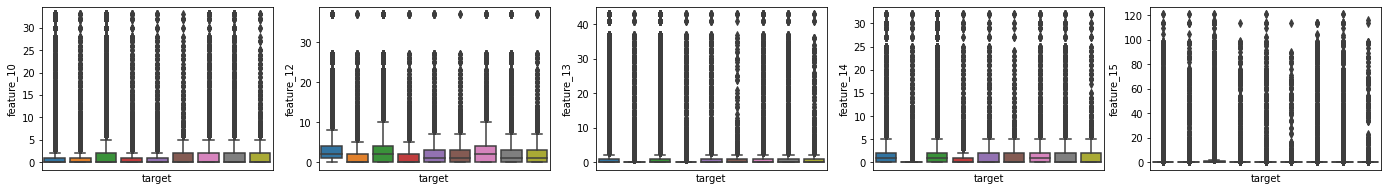

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

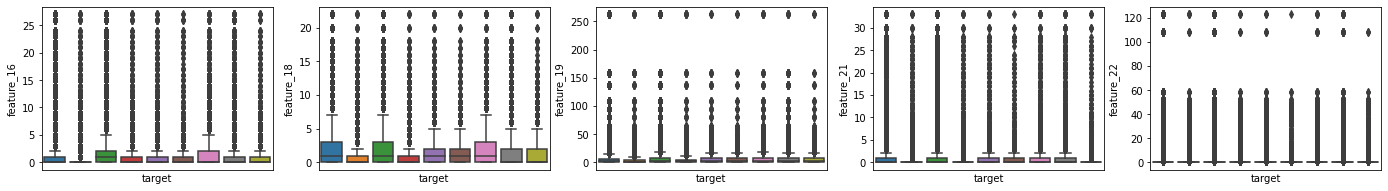

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

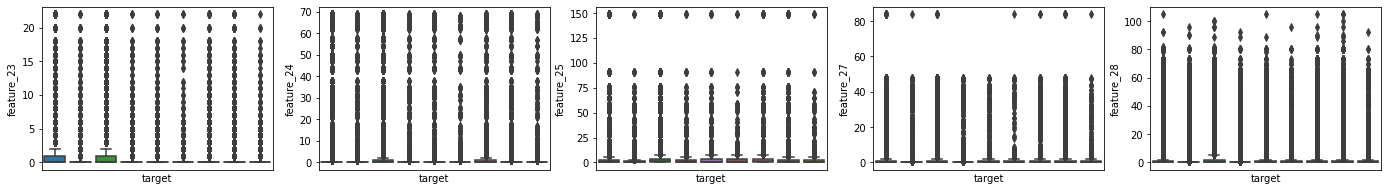

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

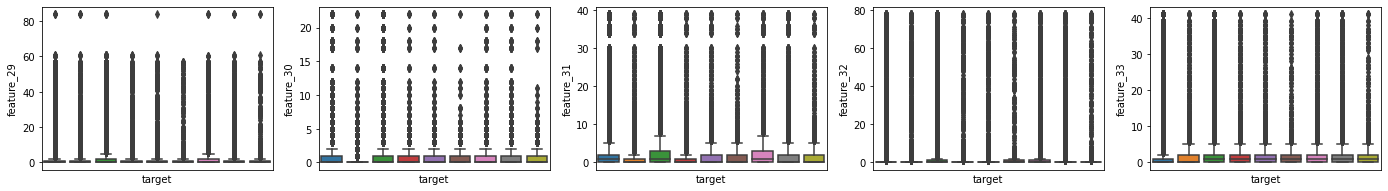

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

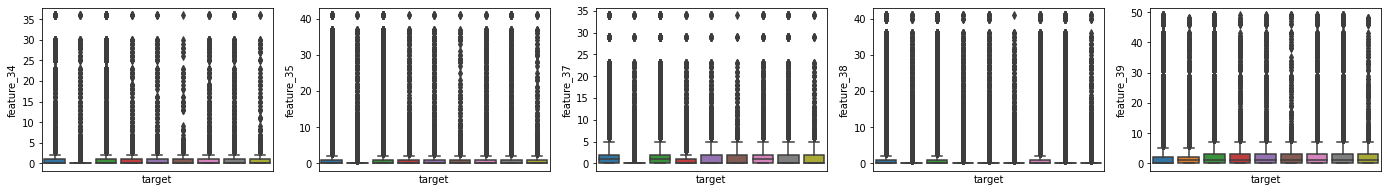

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

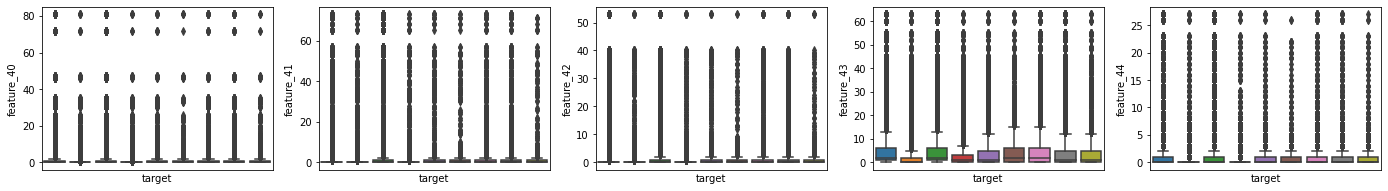

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

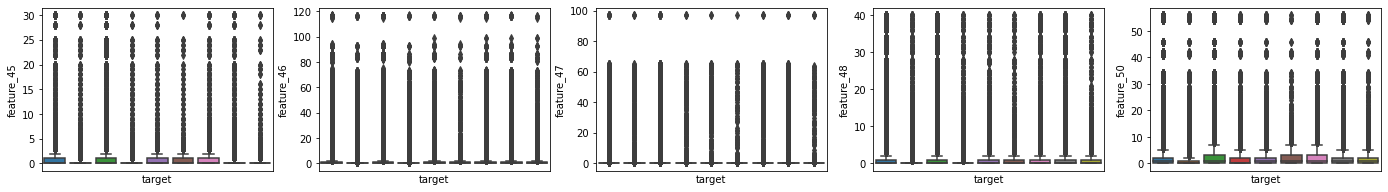

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

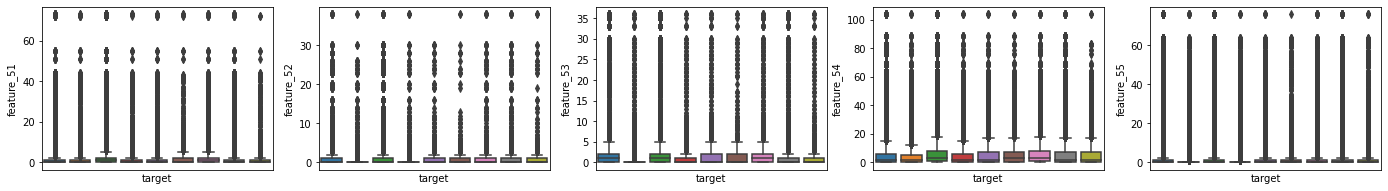

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

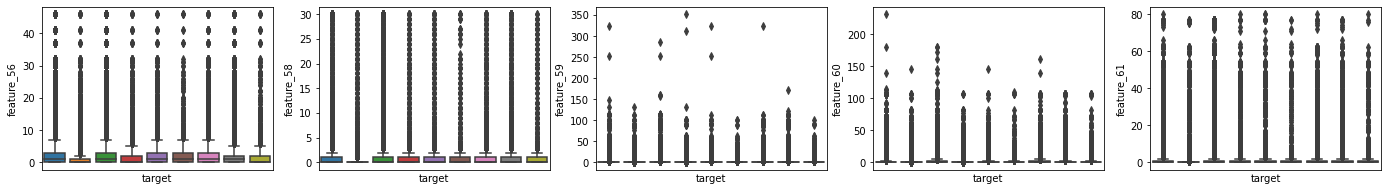

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

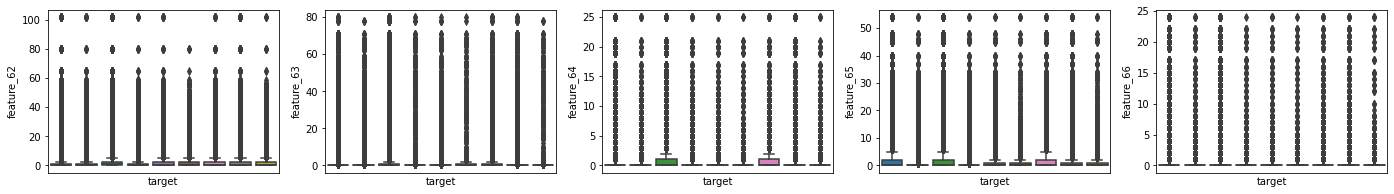

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

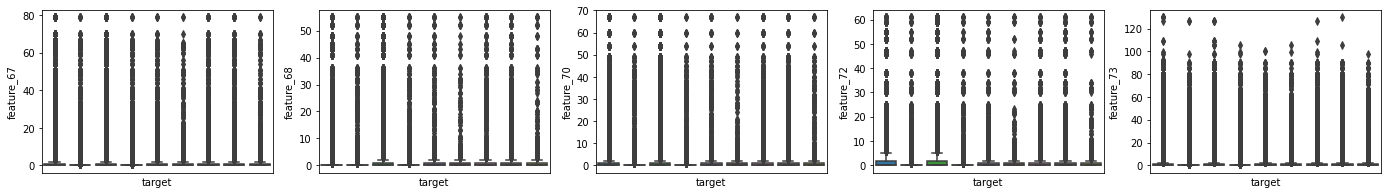

In [20]:
fig,axes = plt.subplots(1,5,figsize=(24,3))
i=1
for col in train_df.columns[1:-1]:
    plt.subplot(1,5,i)
    sns.boxplot(train_df['target'],train_df[col])
   # plt.yaxis('off')
    plt.xticks([])
    i+=1
    if i%5==1 and col!=train_df.columns[-2]:
        i=1
        plt.show()
        fig,axes = plt.subplots(1,5,figsize=(24,3))

In the boxplots we can see that most of the data is outliers. So, we need to sensitively process data and remove those outliers.

#### Approach:

The approaches has been taken from [here](https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/).

1. Using Interquartile Range .
2. Zscore



In [21]:
from scipy.stats import iqr

In [22]:
# Using interquartile range

temp_df = train_df

for col in temp_df.columns[1:-1]:
    iqr_val = iqr(temp_df[col])
    q1 = np.quantile(temp_df[col] , 0.25)
    q3 = np.quantile(temp_df[col] , 0.75)
    temp_df = temp_df[temp_df[col]>=q1-1.5*iqr_val]
    temp_df = temp_df[temp_df[col]<=q3+1.5*iqr_val]
print(train_df.shape,'--->',temp_df.shape)

(200000, 67) ---> (1591, 67)


In [23]:
from  scipy.stats import zscore

In [24]:
# Using zscore

temp_df = train_df

for col in temp_df.columns[1:-1]:
    temp_df['zs'] = np.abs(zscore(temp_df[col]))
    temp_df = temp_df[temp_df['zs'] <= 3.0]
    temp_df.drop('zs' , 1 , inplace = True)
train_df.drop('zs' , 1 , inplace = True)
print(train_df.shape , '--->' , temp_df.shape)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(200000, 67) ---> (84707, 67)


We can see that the IQR method turns the data into a very small shape which will lead us to not learning essential points.
So, we are going to accept the zscore implementation in this notebook.

In [25]:
cleaned_train_df = temp_df

4. #### Dropping ID :

In [26]:
cleaned_train_df.drop('id',1,inplace=True)
idx = test_df['id']
test_df.drop('id',1,inplace=True)

5. #### Dropping Duplicates :
---
Now we are going to drop the duplicate rows and features . This will reduce the dimensionality of the train data.

In [27]:
cleaned_train_df.drop_duplicates(inplace=True)
cleaned_train_df = cleaned_train_df.T.drop_duplicates().T

In [28]:
cleaned_train_df.shape

(83694, 66)

6. #### Checking other features :
---
 Let's check if there's any other pattern if we can find.

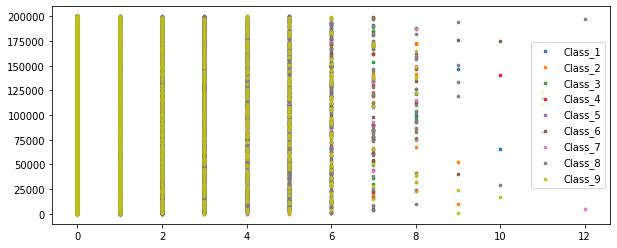

In [29]:
arr = []
plt.figure(figsize=(10,4))
for i in range(1,10):
    t_df =temp_df[temp_df['target']=='Class_'+str(i)]
    plt.scatter(t_df['feature_0'],t_df.index,label='Class_'+str(i),s=7)
plt.legend()
plt.show()

Look's like we can forward to the next step.

7. #### Splitting the data into train and validation :
---
 We are going to have a 80-20 train validation split, also we are going to change the target feature(basically change that into numerical values).

In [30]:
from sklearn.model_selection import train_test_split

In [34]:
def split_data(test_size,data):
    data = data.sample(frac=1)
    x_train = data.drop('target',1)
    y_1 = data['target']
    x_train = x_train
    y_1 = y_1.to_numpy()
    X_train , X_val , y_1 , y_2 = train_test_split( x_train , y_1 ,
                                                         test_size = test_size ,
                                                        random_state =1 ,
                                                        stratify = y_1)
    y_train = []
    y_val = []
    for value in y_1:
        y_train.append(int(value[-1])-1)
    for value in y_2:
        y_val.append(int(value[-1])-1)
    return X_train , X_val , np.array(y_train) , np.array(y_val)

In [35]:
X_train , X_val , y_train , y_val = split_data(0.2,cleaned_train_df)
X_test = test_df[X_train.columns]

In [36]:
X_train.shape , X_val.shape , y_train.shape , y_val.shape , X_test.shape

((66955, 65), (16739, 65), (66955,), (16739,), (100000, 65))

8. #### Scaling :
---
Now we need to scale the data as different magnitude of data may create irregular clusters.

In [40]:
from sklearn.preprocessing import StandardScaler as scaler

In [45]:
def scale(train,test,validation):
  sc = scaler()
  columns = train.columns
  train = sc.fit_transform(train)
  test = sc.transform(test)
  validation = sc.transform(validation)

  train = pd.DataFrame(train , columns = columns)
  test = pd.DataFrame(test , columns = columns)
  validation = pd.DataFrame(validation , columns = columns)

  return train , test , validation

In [46]:
X_train , X_test , X_val = scale(X_train , X_test , X_val)

In [47]:
X_train.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_12,feature_13,feature_14,feature_15,feature_16,feature_18,feature_19,feature_21,feature_22,feature_23,feature_24,feature_25,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_70,feature_72,feature_73
0,-0.341163,2.528819,-0.353204,-0.357774,-0.26388,-0.485454,-0.341376,-0.307866,-0.418349,-0.330184,-0.535619,-0.712157,-0.353895,-0.511601,-0.21951,-0.398379,-0.599401,-0.622797,-0.410117,-0.275603,-0.382081,-0.290291,-0.487209,-0.402156,-0.374430,-0.411611,-0.445663,-0.506723,-0.284513,-0.625926,-0.445256,-0.462840,-0.536842,-0.309507,-0.217113,-0.385712,-0.320901,-0.367765,-0.077141,-0.421141,-0.341939,-0.258788,-0.262598,-0.39655,-0.576412,-0.498534,-0.385261,-0.520367,-0.214670,-0.249133,-0.553048,-0.454816,-0.365374,-0.404127,-0.402987,-0.375373,-0.2941,-0.311262,-0.416424,-0.301739,-0.29453,-0.370356,-0.390468,-0.448026,-0.270242
1,-0.341163,-0.308755,2.029739,-0.357774,-0.26388,-0.485454,-0.341376,-0.307866,0.014200,-0.330184,-0.535619,0.224805,-0.353895,-0.511601,-0.21951,-0.398379,2.055417,-0.622797,0.564380,-0.275603,1.050697,-0.290291,-0.002137,-0.402156,0.401178,0.448277,1.169371,-0.506723,-0.284513,-0.625926,-0.445256,4.516506,-0.536842,0.592201,-0.708718,0.573411,-0.320901,-0.367765,0.202879,-0.421141,-0.341939,-0.258788,-0.262598,-0.39655,-0.001271,-0.498534,1.405570,1.258741,3.352775,-0.249133,-0.553048,-0.454816,-0.365374,-0.404127,-0.402987,-0.375373,-0.2941,-0.311262,3.930129,1.688895,-0.29453,-0.370356,-0.390468,-0.448026,-0.270242
2,-0.341163,-0.308755,-0.353204,-0.357774,-0.26388,-0.485454,0.857575,-0.307866,-0.418349,-0.330184,0.144430,-0.243676,-0.353895,-0.511601,-0.21951,-0.398379,-0.599401,-0.622797,-0.410117,-0.275603,-0.382081,-0.290291,-0.487209,-0.402156,0.401178,-0.411611,-0.445663,-0.506723,-0.284513,0.109395,-0.445256,-0.462840,-0.536842,-0.309507,-0.708718,-0.385712,-0.320901,-0.367765,-0.637182,-0.421141,-0.341939,-0.258788,3.717985,-0.39655,-0.576412,0.391866,-0.385261,-0.520367,0.260989,-0.249133,-0.553048,2.164614,3.703245,-0.404127,4.560583,-0.375373,-0.2941,-0.311262,-0.416424,-0.301739,-0.29453,-0.370356,-0.390468,-0.448026,-0.270242
3,-0.341163,-0.308755,-0.353204,-0.357774,-0.26388,-0.485454,-0.341376,1.215537,-0.418349,-0.330184,-0.535619,-0.712157,-0.353895,-0.511601,-0.21951,-0.398379,-0.599401,0.168395,4.462370,-0.275603,-0.382081,-0.290291,-0.487209,-0.402156,-0.374430,-0.411611,-0.445663,-0.506723,-0.284513,0.844715,-0.445256,-0.462840,-0.536842,-0.309507,-0.708718,-0.385712,-0.320901,1.083933,-0.637182,-0.421141,2.918925,-0.258788,-0.262598,-0.39655,-0.576412,-0.498534,-0.385261,-0.520367,-0.690330,-0.249133,-0.553048,-0.454816,-0.365374,-0.404127,-0.402987,-0.375373,-0.2941,-0.311262,-0.416424,-0.301739,-0.29453,-0.370356,-0.390468,-0.448026,-0.270242
4,-0.341163,-0.308755,1.076561,-0.357774,-0.26388,1.215502,-0.341376,-0.307866,0.014200,-0.330184,0.824479,0.224805,0.714219,0.268678,-0.21951,-0.398379,0.064304,0.761788,-0.410117,-0.275603,-0.382081,2.789964,-0.487209,-0.402156,0.401178,-0.411611,-0.445663,1.422079,-0.284513,-0.625926,2.698155,0.533029,1.862106,-0.309507,-0.708718,1.532535,4.572280,-0.367765,-0.077141,-0.421141,-0.341939,-0.258788,-0.262598,-0.39655,-0.001271,-0.498534,1.405570,3.037849,-0.690330,-0.249133,0.037494,-0.454816,-0.365374,-0.404127,-0.402987,0.145920,-0.2941,-0.311262,1.756852,1.688895,-0.29453,-0.370356,-0.390468,0.556884,-0.270242


Now, we will check again the target mass distribution.

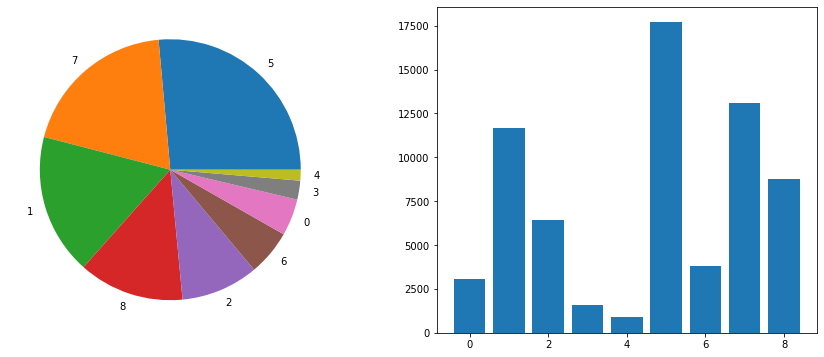

In [35]:
# Target Value Count Distribution:
tm = pd.DataFrame(y_train,columns=['x'])
target_mass = tm['x'].value_counts()
values = target_mass.values.tolist()
indexes = target_mass.index.tolist()

ax,fig = plt.subplots(1,2,figsize=(15,6))
plt.subplot(1,2,1)
plt.pie(values , labels = indexes)
plt.subplot(1,2,2)
plt.bar(indexes,values)
plt.show()

It changed heavily :O

### Model Generation and Evaluation :

 As the model is training and predicting on a single data feature we might not get the correct accuracy metric. So , we are fitting and generating submission files.

In [36]:
# importing models

from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.ensemble import ExtraTreesClassifier as ext
from xgboost import XGBClassifier as xgb
from lightgbm import LGBMClassifier as lgb
from catboost import CatBoostClassifier as cbt

In [37]:
# Function to train and visualize accuracy and predict

def train_and_predict(model , x_1  , x_2 , x_3 , y_1 , y_2):
    labels = []
    for i in range(9):
        labels.append('Class_'+str(i+1))
    model.fit(x_1 , y_1)
    print('Training Completed..........')
    print('Train Accuracy : ',model.score(x_1,y_1))
    print('Validation Accuracy : ',model.score(x_2 , y_2))
    print('Model Prediction started....')
    y_pred = model.predict_proba(x_3)
    final_df = pd.DataFrame(y_pred , columns = labels)
    final_df = pd.concat([idx,final_df]  , axis = 1)    #uncomment this to find the actual submission files.
    
    return final_df

In [38]:
clf1 = rfc(random_state = 2)
clf2 = ext(random_state = 2)
clf3 = xgb()
clf4 = lgb()
clf5 = cbt(verbose=0)
models = [ clf1 , clf2 , clf3 , clf4 , clf5]
names = ['rfc' , 'ext' , 'xgb' , 'lgb' , 'cbt']

In [ ]:
for i in range(len(models)):
    model = models[i]
    print(names[i] , 'model has been opted for training...........')
    submission = train_and_predict(model , X_train , X_val , X_test , y_train , y_val)
    print('submission file created................................\n\n')
    submission.to_csv(names[i]+'.csv',index=False)
print('Task Completed.............................................')

rfc model has been opted for training...........
Training Completed..........
Train Accuracy :  0.9936673885445448
Validation Accuracy :  0.3439273552780931
Model Prediction started....
submission file created................................


ext model has been opted for training...........
Training Completed..........
Train Accuracy :  0.9936673885445448
Validation Accuracy :  0.3417169484437541
Model Prediction started....
submission file created................................


xgb model has been opted for training...........


# THANK YOU for visiting !!!!

## You can visit my other works at [kaggle](https://www.kaggle.com/sagnik1511/code) or in [Github](https://github.com/sagnik1511?tab=repositories).